# Regresja logistyczna, walidacja krzyżowa, krzywe ROC
Autor: Jarosław Żygierewicz

## Część I: regresja logistyczna
Ten notebook pomoże Ci zapoznać się z regresją logistyczną. 

Zbudujemy klasyfikator bazujący na regresji logistycznej. Jego zadaniem będzie określanie prawdopodobieństwa przyjęcia kandydata na studia na podstawie wyników z dwóch egzaminów maturalnych (każdy przeskalowany na zakres 0-100%): z matematyki i z biologii. 

Zanim przejdziemy do właściwych zadań zaimportujmy potrzebne moduły:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as so

Zestaw uczący pobieramy z repozytorium github i wczytujemy używając klasy Pandas DataFrame. Najpierw pobieramy repozytorium z github. Repozytorium zawiera kod do naszych ćwiczeń, oraz przykładowe dane w katalogu "dane".

In [2]:
#!git clone https://github.com/rav2/uczenie-maszynowe-2021-22

In [3]:
df = pd.read_csv("../uczenie-maszynowe-2021-22/dane/reg_log_data.txt", encoding='latin-1', sep=",", names=["matematyka", "biologia", "wynik"])

Aby łatwiej było się nimi posługiwać wydzielmy z nich dane wejściowe jako 'X' i wyjściowe jako 'Y':

## Analiza wizualna danych. 

Pierwszy krok przy analizie danych z użyciem dowolnego algorytmu to ich inspekcja. Korzystając z metod klasy DataFrame proszę:
* wypisać na ekran framgent danych
* narysować rozkłady wszystkich zmiennych wejściowych, w naszym przypadku wyniku egzaminów z matematyki i biologii dla całego zbioru
* narysować rozkłady wszystkich zmiennych wejściowych, w naszym przypadku wyniku egzaminów z matematyki i biologii dla wierszy gdzie wynik=0
* narysować rozkłady wszystkich zmiennych wejściowych, w naszym przypadku wyniku egzaminów z matematyki i biologii dla wierszy gdzie wynik=1

**Wskazówka**: proszę użyć filtrowania danych, tak jak to było robione na pierwszych zajęciach.

    matematyka   biologia  wynik
0    34.623660  78.024693      0
1    30.286711  43.894998      0
2    35.847409  72.902198      0
3    60.182599  86.308552      1
4    79.032736  75.344376      1
..         ...        ...    ...
95   83.489163  48.380286      1
96   42.261701  87.103851      1
97   99.315009  68.775409      1
98   55.340018  64.931938      1
99   74.775893  89.529813      1

[100 rows x 3 columns]


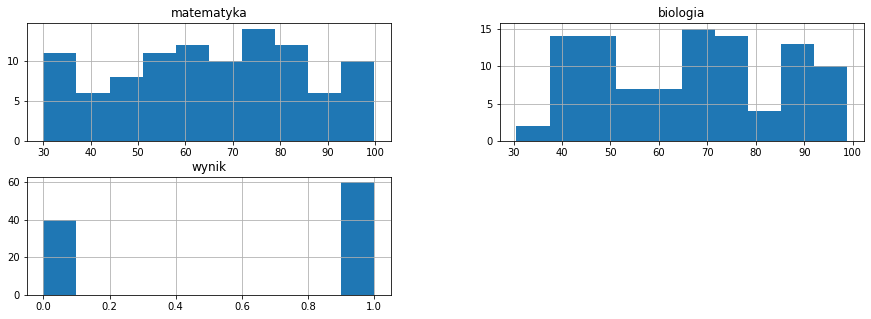

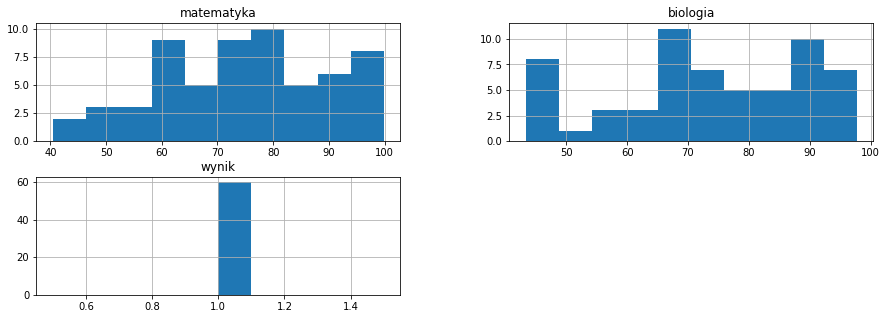

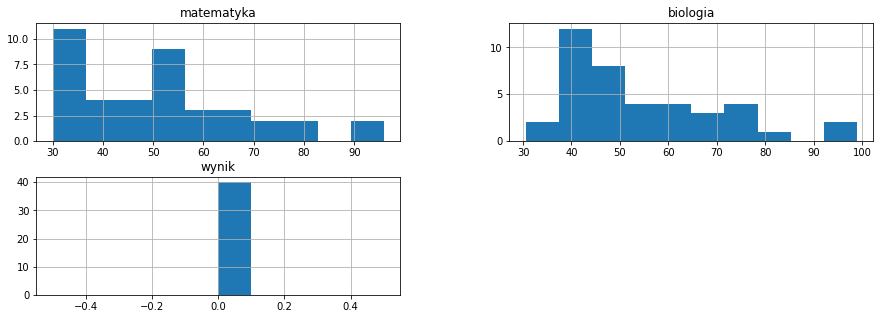

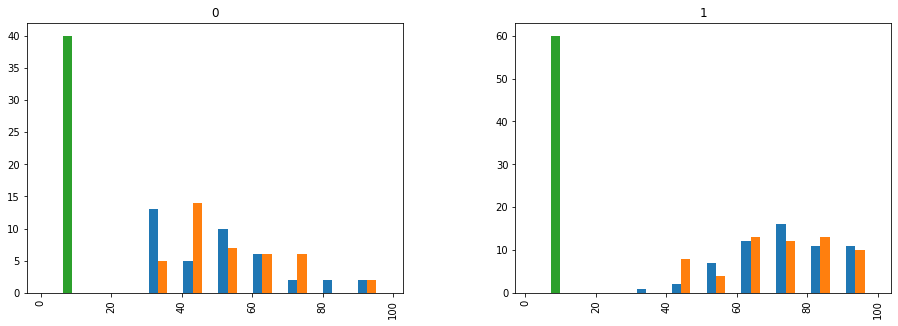

In [4]:
# uzyj tego do okreslenia rozmiaru obrazka
figsize=(15,5)
# wypisz dataframe
print(df)
# wyplotuj wszystko
df.hist(figsize=figsize);
# wyplotuj tych co zdali
df_passed = df[df["wynik"]==1]
df_passed.hist(figsize=figsize);
# wyplotuj tych co nie zdali
df_failed = df[df["wynik"]==0]
df_failed.hist(figsize=figsize);

#To samo co powyżej w jednej linii
df.hist(figsize=figsize, by="wynik");

To co nas interesuje to są jednak korelacje między zmiennymi. Korzystając z przykładu z pierwszych ćwiczeń proszę:

* narysować wykres korelacji między zmiennymi wejściowymi dla pełnych danych, oraz wierszy gdzie wynik=0 lub 1

**Wskazówka**: proszę użyć parametru "hue" funkcji sns.jointplot()

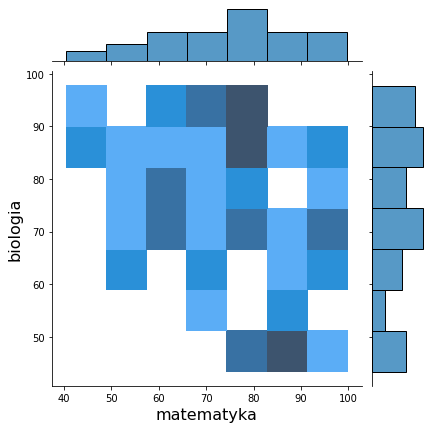

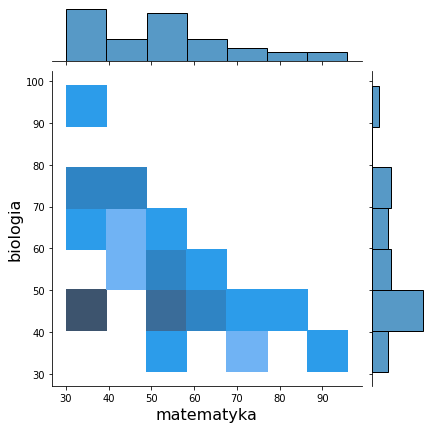

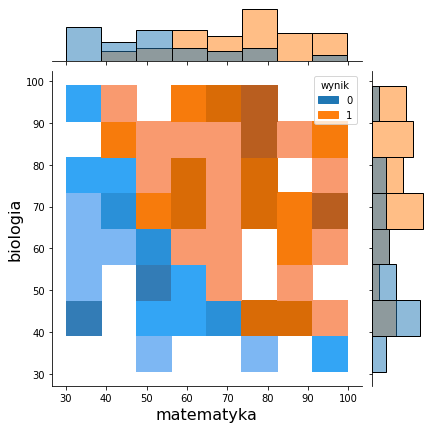

In [5]:
import seaborn as sns

x = sns.jointplot(x="matematyka", y="biologia", data=df_passed, kind='hist')
x.set_axis_labels('matematyka', 'biologia', fontsize=16);

x = sns.jointplot(x="matematyka", y="biologia", data=df_failed, kind='hist')
x.set_axis_labels('matematyka', 'biologia', fontsize=16);

x = sns.jointplot(x="matematyka", y="biologia", data=df, kind='hist', hue="wynik")
x.set_axis_labels('matematyka', 'biologia', fontsize=16);

## Hipoteza
Dla przypomnienia _hipoteza_ w regresji logistycznej ma postać: 

$\qquad$ $h_\theta(x) = \frac{1}{1+\exp(-\theta x^T )}$.

W implementacji dobrze jest myśleć o tej funkcji tak:

$\qquad$ $h_\theta(x) = \frac{1}{1+f}$.

gdzie: $f = \exp(-\theta x^T)$

Proszę napisać funkcję ```logistic_func(x, theta)``` która:

* implementuje funkcję logistyczną
* jako argumenty przyjmuje parametry regresji logistycznej  $(\theta_{0}, \theta_{1}, ..., \theta_{i})$ oraz tablicę danych wejściowych $x$. 
* w kodzie fukcji proszę rozszerzyć tablicę $x$ o dodatkową kolumnę jedynek, by parametr $\theta_{0}$ był traktowany na tej same zasadzie co pozostałe parametry
* ze względu na stabilność numeryczną obliczeń ma ograniczony zakres zmienności. Proszę ograniczyć wartości wykładnika w mianowniku do zakresu  $\pm18$

**Ostrzeżenie:** x to tablica która może zawierać wiele kolumn i wiele wierszy.

**Wskazówka**: ograniczając zakres zwracanych wartości proszę skorzystać z funkcji np.where() zaaplikowanej do wektora wartości wykładnika.

Proszę sprawdzić działanie funkcji na następujących danych testowych:
```
theta = np.array([1,1,2])
x = np.array([[5,5],
              [5,6],
              [-5,-5],
              [-5,-8]])
```

In [6]:
theta = np.array([1,1,2])
x = np.array([[5,5],
              [5,6],
              [-5,-5],
              [-5,-8]])
x_expanded = np.column_stack((np.ones(x.shape[0]), x))

np.sum(theta*x_expanded, axis=1)

array([ 16.,  18., -14., -20.])

In [7]:
def logistic_func(theta, x):
    # dodaj kolumne jedynek
    x_expanded = np.column_stack((np.ones(x.shape[0]), x))
    #arg1 = (theta.reshape(1, len(theta)) @ x_expanded.T).reshape(-1)
    # policz argument funkcji
    arg = np.sum(theta*x_expanded, axis=1)
    # uzyj np.where żeby ograniczyc wartosci parmetru do [-18,18]
    arg = np.where(np.abs(arg)<18, arg, 18*np.sign(arg))
    return 1.0/(1+np.exp(-arg))



theta = np.array([1,1,2])
x = np.array([[5,5],
              [5,6],
              [-5,-5],
              [-5,-8]])
res = logistic_func(theta, x)
# poprosze liste o podanym wymiarze na wyniku
assert res.shape == (4,)
print(res)


[9.99999887e-01 9.99999985e-01 8.31528028e-07 1.52299795e-08]


## Funkcja log-wiarygodności: 
Parametry regresji znajdujemy przez maksymalizację [funkcji log-wiarygodności](https://brain.fuw.edu.pl/edu/index.php/Uczenie_maszynowe_i_sztuczne_sieci_neuronowe/Wykład_6#Funkcja_wiarygodno.C5.9Bci):

$\qquad$ $l(\theta) = \log L(\theta) = \sum_{j=1}^m y^{(j)} \log h(x^{(j)}) + (1 - y^{(j)}) \log (1 - h(x^{(j)}))$,
gdzie:  

m - liczebność próbki

x - dane wejściowe, u nas wyniki z egaminów z matematyki i biologii

y - dane wyjściowe, u nas wynik rekrutacji na studia

h - postać zależności wyniku od danych wejściowych. U nas to jest funkcja logistyczna, czyli oczekujemy, że wzór y = h(x) dobrze opisuje zależnośc między danymi wejściowymi, a wyjściowymi.


<hr>

Proszę napisać funkcję ```log_likelihood(theta, x,y, model)``` która:

* implementuje funkcję log-wiarygodności
* jako argumenty przyjmuje parametry regresji logistycznej  $(\theta_{0}, \theta_{1}, ..., \theta_{i})$ oraz tablicę danych wejściowych $x, y$. 
* model dla którego szukamy parametrów $\theta_{i}$ w naszym przypadku to będzie funkcja logistyczna: ```logistic_func```

**Uwaga**: argument $theta$ musi być pierwszy 

In [27]:
def log_likelihood(theta, x, y, model):
    # Miejsce na twój kod. Użyj argumentu model zamiast konkretnej funkcji.
    model_result = model(theta, x)
    result = y*np.log(model_result) + (1-y)*np.log(1-model_result)
    result = np.sum(result)
    return result

Maksymalizacja to zadanie optymalizacyjne - szukamy optymalnych parametrów, a kryterium optymalności to maksymalna wartość funckji log-wiarygodności.
W tym ćwiczeniu zrobimy to za pomocą funkcji optymalizacyjnych z modułu [<tt>scipy.optimize</tt>]( http://docs.scipy.org/doc/scipy/reference/optimize.html#module-scipy.optimize). 


Wynikają z tego dwie konsekwencje:
* funkcje te są przystosowane do szukania minimów funkcji celu. Musimy więc podawać im jako argumenty funkcję minus log-wiarygodności
* niektóre algorytmy mogą działać szybciej jeśli zaimplementujemy jawnie postać pochodnej:

$\qquad$ $
\begin{array}{lcl}
\frac{\partial}{\partial \theta_i} l(\theta)  =\sum_{j=1}^m (y^{(j)}-h_\theta(x^{(j)}))x_i^{(j)}
\end{array}
$

Proszę napisać funkcję ```negative_log_likelihood(theta, x,y, model)``` która:

* zwraca funkcję log-wiarygodności pomnożoną przez $-1$

In [28]:
def negative_log_likelihood(theta, x, y, model):
    return -log_likelihood(theta, x, y, model)

Proszę napisać funkcję ```log_likelihood_derivative(theta, x,y, model)``` oraz ```negative_log_likelihood_derivative(theta, x,y, model)``` które:

* zwraca funkcję pochodną log-wiarygodności
* zwraca funkcję pochodną log-wiarygodności pomnożoną przez $-1$

**Uwaga**: mnożąc przez $x_{i}$ trzeba uwzględnić kolumnę jedynek

In [29]:
def log_likelihood_derivative(theta, x, y, model):
    # Miejsce na Twój kod. Pamiętaj, żeby dodać kolumnę jedynek do x.
    #
    # 1. Policz wynik modelu dzialajacego na danych wejsciowych
    x_expanded = np.column_stack((np.ones(x.shape[0]), x))
    model_result = model(theta, x)
    # 2. Policz różnicę względem danych wyjściowcyh
    delta = np.array(y - model_result)
    # 3. Policz wartość pochodnej pamiętając o sumowaniu
    delta = np.reshape(delta,(-1,1))
    result = delta*x_expanded
    result = np.sum(result, axis=0)
    # 4. zwróc wynik, wartość pochodnej we wszystkich kierunkach (kolumnach)
    assert result.shape == theta.shape
    return result

def negative_log_likelihood_derivative(theta, x, y, model):
    return -log_likelihood_derivative(theta, x, y, model)

## Procedura minimalizacji funkcji log-wiarygodności ze wsględu na parametry $\theta$ dla konkretnych danych.

W naszym przypadku mamy trzy parametry $\theta$ - mnożące odpowiednio 1, wynik z matematyki, wynik z biologii.

Proszę:
* zainicjalizować parametry $\theta_{0}, \theta_{1}, \theta_{2}$ na wartości 0.
* obliczyć wartość i pochodną funkcji wiarygodności na danych początkowych 

Poprawne wartości to:
```
Wartość funkcji log-wiarygodności dla zbioru testowego = -69.31471805599453
Wartość pochodnej funkcji log-wiarygodności dla zbioru testowego = [  10.         1200.92165893 1126.28422055]
```

In [30]:
theta0 = np.array([0,0,0])

model = logistic_func

# wartość funkcji log-wiarygodności
llh = log_likelihood(theta0, df[["matematyka","biologia"]], df["wynik"], model)
# wartość pochodnej
llh_derivative = log_likelihood_derivative(theta0, df[["matematyka","biologia"]], df["wynik"], model)

print("Wartość funkcji log-wiarygodności dla zbioru testowego = {}".format(llh))
print("Wartość pochodnej funkcji log-wiarygodności dla zbioru testowego = {}".format(llh_derivative))

Wartość funkcji log-wiarygodności dla zbioru testowego = -69.31471805599453
Wartość pochodnej funkcji log-wiarygodności dla zbioru testowego = [  -31.         -1475.63866911 -1526.82006556]


## Optymalizacja  

Funkcje optymalizujące zaczerpniemy z modułu scipy.optimize: ```scipy.optimize.fmin_bfgs```. Ponieważ funkcje te są zaimplementowane do mnimalizowania to zamiast maksymalizować funkcję low-wiarygodności będziemy minimalizować tą funkcje przemnożoną przez -1 czyli ```f=negative_log_likelihood``` oraz ```fprime=negative_log_likelihood_derivative```


* proszę wywołać funckję ```scipy.optimize.fmin_bfgs``` z obpowiednimi argumentami.
* proszę porównać liczbę wywołań i czas wykonywania komórki z i bez podania explicite postaci pochodnej
(https://ipython.readthedocs.io/en/stable/interactive/magics.html?highlight=%25time#cell-magics)

In [12]:
%%time 
# ^ rozpoczecie mierzenia czasu dzieje sie tu


model = logistic_func
print(theta)
# znajdz optymalne parametry theta
theta_opt = so.fmin_bfgs(f=negative_log_likelihood, x0=theta0, 
                         #fprime=negative_log_likelihood_derivative, 
                         args=(df[["matematyka","biologia"]], df["wynik"], model), disp= True)
# policz log-wiarygosnosc z optymalnymi parametrami
llh = log_likelihood(theta_opt, df[["matematyka","biologia"]], df["wynik"], model)

print('Optymalne wartości parametrów theta: {}'.format(theta_opt))
print("Wartość funkcji log-wiarygodności dla optymalnych parametrów: {}".format(llh))

[1 1 2]
Optimization terminated successfully.
         Current function value: 20.349770
         Iterations: 21
         Function evaluations: 160
         Gradient evaluations: 40
Optymalne wartości parametrów theta: [-25.16124413   0.20623099   0.20147087]
Wartość funkcji log-wiarygodności dla optymalnych parametrów: -20.34977015906372
CPU times: user 225 ms, sys: 13.8 ms, total: 239 ms
Wall time: 244 ms


## Wyniki
Wyniki regresji logistycznej możemy odbierać na dwa sposoby:
* obliczyć wartość hipotezy dla badanego wejścia i dopasowanych parametrów: miara ta ma interpretację prawdopodobieństwa przynależności wejścia do klasy 1,
* dopisać funkcję wykonującą klasyfikację, tzn. porównanie wartości hipotezy z 1/2: 
  * dla wartości hipotezy > 1/2 klasyfikacja zwraca 1, 
  * w przeciwnym razie 0.
  
  
Proszę napisać funkcję ```classification(theta, x)```  która:
* jako argument przyjmuje wektora parametrów modelu $\theta$, tablicę danych wejściowych $x$, oraz $model$
* zwraca listę klasyfikacyjną: $1$ gdy $model(x)>0.5$, a $0$ w przeciwnym przypadku

In [13]:
def classification(theta, x, model):
    model_result = model(theta, x)
    return model_result>0.5

## Przewidywanie 

Proszę:

* korzystając z modelu ```logistic_func``` wraz z parametrami zwróconymi przez procedurę optymalizacyjną obliczyć prawdopobobieństwo zdania
  osoby, która uzyskała 20 pkt. z matematyki, oraz 80 z biologii.
* korzystając z funckji "classification" wyznaczyć czy osoba należy do   klasy $0$ czy $1$.

In [14]:
# stworz dane odpowiadajace naszej osobie
x = np.array([[20, 80]])
# policz prawdopodobienstwo zdania
p = model(theta_opt, x)

print("Osoba z {} pkt z matematyki, oraz {} pkt. z biologii ma {}% szans na przyjęcie na studia.".format(x[0,0], x[0,1], round(p[0]*100,3)))

# sklasyfikuj osobę
class_number = classification(theta_opt, x, model).astype(int)
print("Osoba zalicza się do klasy: {}".format(class_number))

Osoba z 20 pkt z matematyki, oraz 80 pkt. z biologii ma 0.725% szans na przyjęcie na studia.
Osoba zalicza się do klasy: [0]


Narysujmy uzyskany podział. Na tle punktów pokolorowanych zgodnie z przynależnością do klas dorysujemy prostą rozgraniczającą obszary "1" od "0".   Ma ona równanie 

$\qquad$ $h_\theta(x)=1/2$, 

tzn:

$\qquad$ $\theta x^T = 0$

czyli 

$\theta_0 +\theta_1 x_1 + \theta_2 x_2 =0 $

Przekształcając to do równania prostej we współrzędnych $(x_1,x_2)$ mamy:

$- \theta_2 x_2 = \theta_0 +\theta_1 x_1 $

$ x_2 = - \frac{1}{\theta_2}( \theta_0 +\theta_1 x_1 )$

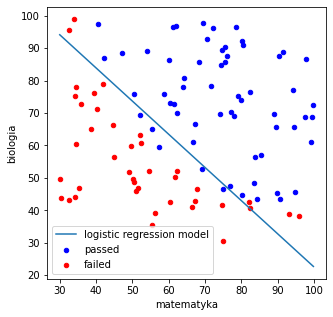

In [15]:
df_passed = df[df["wynik"]==1]
df_failed = df[df["wynik"]==0]

fig, axes = plt.subplots(1,1, figsize=(5,5))
# narysuj tych co zdali na niebiesko, pamietaj o argumencie "label" dla czytelnosci
df_passed.plot(x="matematyka",y="biologia", ax=axes, kind="scatter", label="passed", c="blue")
# narysuj tych co nie zdali na czerwono, pamietaj o argumencie "label" dla czytelnosci
df_failed.plot(x="matematyka",y="biologia", ax=axes, kind="scatter", label="failed", c ="red");

# znajdz prostą
x = np.array([df["matematyka"].min(),df["matematyka"].max()])
y = -(theta_opt[0] + theta_opt[1]*x)/theta_opt[2]

# rysowanie prostej i legendy
axes.plot(x,y, label="logistic regression model")
axes.legend();

## Część II: Walidacja - to na ćwiczenia w przyszłym tygodniu
Teoria do tej części znajduje się tu:

https://brain.fuw.edu.pl/edu/index.php/Uczenie_maszynowe_i_sztuczne_sieci_neuronowe/Wykład_Ocena_jakości_klasyfikacji

### Zastosowanie w naszym przykładzie
Dodamy teraz kross-walidację typu $leave-one-out$.
Po kolei odłożymy po jednym przykładzie ze zbioru uczącego i na takim zredukownaym zbiorze nauczymy regresję, a następnie sprawdzimy 
działanie modelu na odłożonym przykładzie:

<ol>
<li> ze zbioru uczącego odrzucamy jeden przykład </li>
<li> na pozostałych przykładach "trenujemy model", czyli znajdujemy parametry $\theta$ </li>
<li> sprawdzamy działanie modelu na odrzuconym wcześniej przykładzie</li>
<li> procedurę powtarzamy dla wszystkich przykładów w zbiorze uczącym </li>   
</ol> 

Proszę napisać funckję ```leave_one_out_CV(df, theta, model)```

która:
* przyjmuje zestaw uczący w postaci obiektu DataFrame, początkowych parametrów $\theta$, oraz model $model$
* wykonuje operację "leave-one-out" i tworzy listę wyników modelu dla każdego przykładu:

```
passed = np.append(passed, classification(theta_opt, df_left_out[["matematyka","biologia"]], model))
```

* dodaje do obiektu DataFrame kolumnę z wynikami modelu:

```
df["model"] = passed 
```   

In [16]:
%%time 

def leave_one_out_CV(df, theta0, model):
    # tutaj bedziemy wpisywac wyniki modelu
    passed = np.array([])
    # tworzymy kopie data frame
    df_with_model = df.copy()
    
    # pętla po wszystkich przykładach
    for leave_out_index in df.index:
        # 1. stworz dataframe bez jednego przykladu
        df_filtered = df[df.index!=leave_out_index]
        # 2. znajdz optymalne parametry theta
        theta_opt = so.fmin_bfgs(f=negative_log_likelihood, x0=theta0, 
                         fprime=negative_log_likelihood_derivative, 
                         args=(df_filtered[["matematyka","biologia"]], df_filtered["wynik"], model), disp=False)
        # 3. stworz dataframe z odrzuconego (pojedynczego) przykladu
        df_left_out = df[df.index==leave_out_index]
        # 4. dodajemy wynik modelu do poprzednich
        passed = np.append(passed, classification(theta_opt, df_left_out[["matematyka","biologia"]], model))
    # Dodajemy wyniki modelu do calego data frame
    df_with_model["model"] = passed
    # zwracamy data frame powiekszony o kolumne z wynikami modelu
    return df_with_model
                        
theta0 = np.array([0,0,0])
model = logistic_func 
df_with_model = leave_one_out_CV(df, theta0, model)
print(df_with_model)

    matematyka   biologia  wynik  model
0    34.623660  78.024693      0    0.0
1    30.286711  43.894998      0    0.0
2    35.847409  72.902198      0    0.0
3    60.182599  86.308552      1    1.0
4    79.032736  75.344376      1    1.0
..         ...        ...    ...    ...
95   83.489163  48.380286      1    1.0
96   42.261701  87.103851      1    1.0
97   99.315009  68.775409      1    1.0
98   55.340018  64.931938      1    0.0
99   74.775893  89.529813      1    1.0

[100 rows x 4 columns]
CPU times: user 3.67 s, sys: 12.2 ms, total: 3.68 s
Wall time: 3.68 s


Zdefiniujmy następujące przypadki gdy nasz model się myli lub podaje poprawny wynik:

* "True Positive" (TP):  stan faktyczny jest pozytywny (y=1) i klasyfikator się nie myli (wynik = 1)
* "True Negative" (TN):  stan faktyczny jest negatywny (y=0) i klasyfikator się nie myli (wynik = 0) 
* "False Positive" (FP): wynik fałszywie pozytywny (fałszywy alarm): stan faktyczny jest negatywny (y=0) ale klasyfikator się  myli (wynik = 1)
* "False Netative" (FN): przegapiony alarm: stan faktyczny jest pozytywny (y=1) i klasyfikator się myli (wynik = 0)

Proszę napisać kod, który oblicza TP, TN, FP, FN. Dla naszego zbioru uczącego powinniśmy uzyskać:
```
TP:  55
FP:  6
TN:  34
FN:  5
```   

**Wskazówka:** proszę zliczać liczbę wierszy w odpowiednio przefiltrowanym obiekcie DataFrame

In [17]:
# podpowiedz: uzyj warunkow logicznych aby wybrac odpowiednie dane i pola shape aby dostac liczbe wierszy
tp = df_with_model[(df_with_model["model"]>0.5)&(df_with_model["wynik"]==1)].shape[0]
fp = df_with_model[(df_with_model["model"]>0.5)&(df_with_model["wynik"]==0)].shape[0]
tn = df_with_model[(df_with_model["model"]<0.5)&(df_with_model["wynik"]==0)].shape[0]
fn = df_with_model[(df_with_model["model"]<0.5)&(df_with_model["wynik"]==1)].shape[0]

print("TP = {}\nFP = {}\nTN = {}\nFN = {}".format(tp, fp, tn, fn))

TP = 55
FP = 6
TN = 34
FN = 5


## Krzywa ROC

Aby wykreślić krzywą ROC należy przeprowadzić klasyfikację dla wielu możliwych wartości progu dla hipotezy, powyżej którego uznajemy przypadek za należący do klasy 1. W tym celu należy zmodyfikować funckję ```leave_one_out_CV(df, theta0, model)``` tak by zapisywała prawdopodobieństwo, a nie wynik działania funkcji ```classification```

Proszę napisać funkcję ```leave_one_out_CV_with_prob(df, theta0, model)``` 
* która zapisuje kolumnę z prawdopodobieństwem zamiast wynikiem klasyfikacji

In [18]:
%%time 

def leave_one_out_CV_with_prob(df, theta0, model):
    # tutaj bedziemy wpisywac wyniki modelu (prawdopodobienstwa)
    prob = np.array([])
    # robimy kopie oryginalnych danych do ktorych dodamy kolumne
    df_with_model = df.copy()
    # petla po wszystkich przykladach
    for leave_out_index in df.index:
        # 1. stworz dataframe bez jednego przykladu
        df_filtered = df[df.index!=leave_out_index]
        # 2. znajdz optymalne parametry theta
        theta_opt = so.fmin_bfgs(f=negative_log_likelihood, x0=theta0, 
                         fprime=negative_log_likelihood_derivative, 
                         args=(df_filtered[["matematyka","biologia"]], df_filtered["wynik"], model), disp=False)
        # 3. stworz dataframe z odrzuconego (pojedynczego) przykladu
        df_left_out = df[df.index==leave_out_index]
        # 4. dodajemy wynik modelu do poprzednich
        prob = np.append(prob, model(theta_opt, df_left_out[["matematyka","biologia"]]))
    # Dodajemy wyniki modelu (prawdopodobienstwa) do calego data frame
    df_with_model["model_prob"] = prob
    # zwracamy data frame powiekszony o kolumne z wynikami modelu (prawdopodobienstwami)
    return df_with_model
                        
theta0 = np.array([0,0,0])
model = logistic_func 
df_with_prob = leave_one_out_CV_with_prob(df, theta0, model)
print(df_with_prob)

    matematyka   biologia  wynik  model_prob
0    34.623660  78.024693      0    0.096879
1    30.286711  43.894998      0    0.000042
2    35.847409  72.902198      0    0.045566
3    60.182599  86.308552      1    0.990292
4    79.032736  75.344376      1    0.998192
..         ...        ...    ...         ...
95   83.489163  48.380286      1    0.850268
96   42.261701  87.103851      1    0.721421
97   99.315009  68.775409      1    0.999897
98   55.340018  64.931938      1    0.306822
99   74.775893  89.529813      1    0.999751

[100 rows x 4 columns]
CPU times: user 3.62 s, sys: 15.4 ms, total: 3.64 s
Wall time: 3.65 s


Korzystając z biblioteki ```sklearn``` proszę narysować krzywą ROC oraz obliczyć pole pod nią ("area unde ROC, AUC) dla naszego modelu.

**Wskazówka:** wpisać w Google hasło "scikit learn Receiver Operating Characteristic"

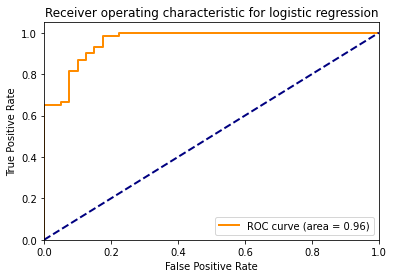

In [19]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

fpr, tpr, thresholds = roc_curve(df_with_prob["wynik"], df_with_prob["model_prob"])
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
# narysujmy krzywą (diagonala) dla rzutu monetą (naiwny klasyfikator, najgorsze rozwiązanie)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for logistic regression')
plt.legend(loc="lower right")
plt.show()

## Modyfikacja modelu

Proszę wykonać trening regresji logistycznej dla modelu, który używa wyniku tylko z jednego egzaminu i narysować na jednym rysunku krzywe ROC dla trzech wariantów:
* modelu używającego wyników z obu przedmiotów
* modelu używającego tylko wyników z matematyki
* modelu używającego tylko wyników z biologii

**Wskazówka**: należy przerobić funkcję ```leave_one_out_CV_with_prob``` tak by wykonywała obliczenia dla wszystkich trzech wariantów

In [20]:
%%time

def leave_one_out_CV_many_models(df, theta0, model):
    # tu zapisujemy wszystkie prawdopodobienstwa
    prob = np.array([])
    # tu tylko dla matematyki
    prob_math = np.array([])
    # tu tylko dla biologii
    prob_biol = np.array([])
    # tu robimy kopie
    df_with_model = df.copy()
    
    for leave_out_index in df.index:
        # robimy podobnie jak poprzednio, ale tym razem 3 razy: dla obu dziedzin, tylko dla majcy, tylko dla biologii
        df_filtered = df[df.index!=leave_out_index]
        df_left_out = df[df.index==leave_out_index]
        ###########
        theta_opt = so.fmin_bfgs(f=negative_log_likelihood, x0=theta0, 
                         fprime=negative_log_likelihood_derivative, 
                         args=(df_filtered[["matematyka","biologia"]], df_filtered["wynik"], model), disp=False)
        prob = np.append(prob, model(theta_opt, df_left_out[["matematyka","biologia"]]))
        ##########
        theta_opt = so.fmin_bfgs(f=negative_log_likelihood, x0=theta0[0:2], 
                         fprime=negative_log_likelihood_derivative, 
                         args=(df_filtered["matematyka"], df_filtered["wynik"], model), disp=False)
        prob_math = np.append(prob_math, model(theta_opt, df_left_out[["matematyka"]]))
        #########
        theta_opt = so.fmin_bfgs(f=negative_log_likelihood, x0=theta0[0:2], 
                         fprime=negative_log_likelihood_derivative, 
                         args=(df_filtered["biologia"], df_filtered["wynik"], model), disp=False)
        prob_biol = np.append(prob_biol, model(theta_opt, df_left_out[["biologia"]]))
        ##########
    # dodajemy kolumny do data frame i zwracamy
    df_with_model["model_prob"] = prob
    df_with_model["model_prob_matematyka"] = prob_math
    df_with_model["model_prob_biologia"] = prob_biol
    return df_with_model
                        
theta0 = np.array([0,0,0])
model = logistic_func 
df_with_prob = leave_one_out_CV_many_models(df, theta0, model)
print(df_with_prob)

    matematyka   biologia  wynik  model_prob  model_prob_matematyka  \
0    34.623660  78.024693      0    0.096879               0.132115   
1    30.286711  43.894998      0    0.000042               0.096571   
2    35.847409  72.902198      0    0.045566               0.143957   
3    60.182599  86.308552      1    0.990292               0.530217   
4    79.032736  75.344376      1    0.998192               0.839340   
..         ...        ...    ...         ...                    ...   
95   83.489163  48.380286      1    0.850268               0.882310   
96   42.261701  87.103851      1    0.721421               0.191751   
97   99.315009  68.775409      1    0.999897               0.964477   
98   55.340018  64.931938      1    0.306822               0.429564   
99   74.775893  89.529813      1    0.999751               0.787323   

    model_prob_biologia  
0              0.816447  
1              0.276754  
2              0.750268  
3              0.875439  
4              0.

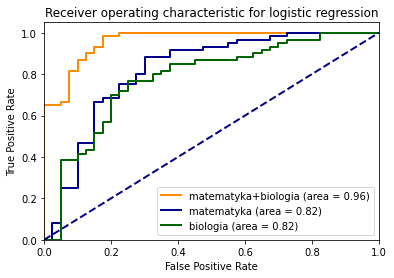

In [21]:
# analogicznie jak poprzednio, ale tym razem liczymy i plotujemy 3 ROC 
fpr, tpr, thresholds = roc_curve(df_with_prob["wynik"], df_with_prob["model_prob"])
fpr_math, tpr_math, thresholds = roc_curve(df_with_prob["wynik"], df_with_prob["model_prob_matematyka"])
fpr_biol, tpr_biol, thresholds = roc_curve(df_with_prob["wynik"], df_with_prob["model_prob_biologia"])

roc_auc = auc(fpr, tpr)
roc_auc_math = auc(fpr_math, tpr_math)
roc_auc_biol = auc(fpr_biol, tpr_biol)

plt.figure()
lw = 2
# uzupelnij kod poniżej
plt.plot(fpr, tpr, color='darkorange',lw=lw, label='matematyka+biologia (area = %0.2f)' % roc_auc)
plt.plot(fpr_math, tpr_math, color='darkblue',lw=lw, label='matematyka (area = %0.2f)' % roc_auc_math)
plt.plot(fpr_biol, tpr_biol, color='darkgreen',lw=lw, label='biologia (area = %0.2f)' % roc_auc_math)
#
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for logistic regression')
plt.legend(loc="lower right")
plt.show()

## Zastosowanie do innego rodzaju danych

Proszę przeprowadzić procedurę treningu i narysować krzywą ROC dla danych gdzie występuje inny podział między klasami:


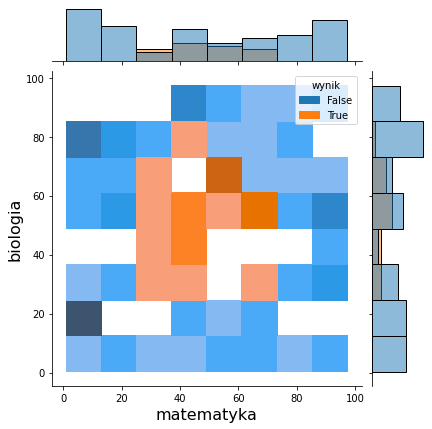

In [22]:
nPoints = 100
x = 100*np.random.random_sample(nPoints)
y = 100*np.random.random_sample(nPoints)

df = pd.DataFrame(data=x, columns=["matematyka"])
df["biologia"] = y
# tworzymy nowe dane
df["wynik"] = np.sqrt((x-50)**2 + (y-50)**2)<25
# narysuj dwuwymiarowy wykres aby zobaczy korelacje
x = sns.jointplot(x="matematyka", y="biologia", data=df, kind='hist', hue="wynik")
x.set_axis_labels('matematyka', 'biologia', fontsize=16);

In [23]:
theta0 = np.array([0,0,0])
model = logistic_func
# policz prawdopodobienstwa z modelu przy uzyciu walidacji leave_one_out
df_with_prob = leave_one_out_CV_with_prob(df, theta0, model)
print(df_with_prob)

    matematyka   biologia  wynik  model_prob
0    45.926269  74.411000   True    0.190826
1    60.088653  51.720146   True    0.182010
2    50.269143  64.609756   True    0.188722
3     5.266773   2.839107  False    0.163356
4    85.158238  63.750033  False    0.209377
..         ...        ...    ...         ...
95    4.371252  18.498147  False    0.170463
96   81.149053  52.954530  False    0.200206
97   75.106507  56.949164  False    0.201112
98   52.531317  67.718316   True    0.190123
99   54.916940  68.649330   True    0.190588

[100 rows x 4 columns]


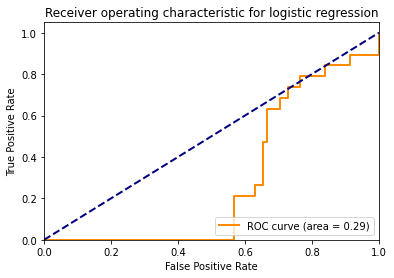

In [24]:
# narysuj ŁADNY wykres z krzywą ROC i wypisz AUC w legendzie
fpr, tpr, thresholds = roc_curve(df_with_prob["wynik"], df_with_prob["model_prob"])
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for logistic regression')
plt.legend(loc="lower right")
plt.show()

## Co można zrobić by poprawić działanie modelu na takich danych?

Napisz funkcję logistic_func_1(theta, x) która będzie działać podobnie do oryginalnej, ale dodaj w niej do oryginalnych danych 3 kolumny: kolumnę jedynek (tak jak poprzednio), kolumnę x1^2, kolumnę x2^2, gdzie x1 i x2 to wyniki z matematyki i biologii odpowiednio.

Następnie uzupełnij funkcję leave_one_out_CV_with_prob(df, theta0, model), analogicznie do poprzednich funkcji. Funkcja ma wykonań walidację leave-one-out i zwrocić prawdopodbieństwo uzyskane z modelu.

In [25]:
%%time

def logistic_func_1(theta, x):
    #x = np.reshape(x.to_numpy(), (x.shape[0],-1))
    x_expanded = np.column_stack((np.ones(x.shape[0]), x*x, x))
#     print(x, (x*x))
#     exit()
    arg = np.sum(theta*x_expanded, axis=1)
    arg = np.where(np.abs(arg)<18, arg, 18*np.sign(arg))
    return 1.0/(1+np.exp(-arg))

def leave_one_out_CV_with_prob(df, theta0, model):
    
    prob = np.array([])
    df_with_model = df.copy()
    # napisz petle po przypadkach analoficznie jak poprzednio
    for leave_out_index in df.index:
        df_filtered = df[df.index!=leave_out_index]
        theta_opt = so.fmin_bfgs(f=negative_log_likelihood, x0=theta0, 
                         args=(df_filtered[["matematyka","biologia"]], df_filtered["wynik"], model), disp=False)
        df_left_out = df[df.index==leave_out_index]
        prob = np.append(prob, model(theta_opt, df_left_out[["matematyka","biologia"]]))
    # dodaj prob jako nową kolumnę
    df_with_model["model_prob"] = prob
    return df_with_model

theta0 = np.array([0,0,0,0,0])
model = logistic_func_1 
df_with_prob = leave_one_out_CV_with_prob(df, theta0, model)
print(df_with_prob)

    matematyka   biologia  wynik    model_prob
0    45.926269  74.411000   True  1.964148e-07
1    60.088653  51.720146   True  1.000000e+00
2    50.269143  64.609756   True  1.000000e+00
3     5.266773   2.839107  False  1.522998e-08
4    85.158238  63.750033  False  1.522998e-08
..         ...        ...    ...           ...
95    4.371252  18.498147  False  1.522998e-08
96   81.149053  52.954530  False  1.522998e-08
97   75.106507  56.949164  False  9.999978e-01
98   52.531317  67.718316   True  1.000000e+00
99   54.916940  68.649330   True  1.000000e+00

[100 rows x 4 columns]
CPU times: user 49.5 s, sys: 170 ms, total: 49.7 s
Wall time: 49.7 s


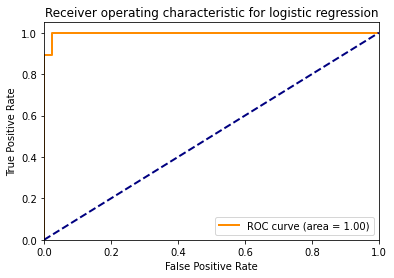

In [26]:
# narysuj ładny wykres ROC tak jak poprzednio ale dla nowego modelu
fpr, tpr, thresholds = roc_curve(df_with_prob["wynik"], df_with_prob["model_prob"])
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for logistic regression')
plt.legend(loc="lower right")
plt.show()